In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from bgspy.utils import load_pickle, mean_ratio
from bgspy.plots import to_mb

In [3]:
plt.show()

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

FIGDIR = '../manuscript/figures/'

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

## The Main Fits

There were numerous test fits along the way as the software was being developed, tested, and scaled. 

These however are the main for the paper.

In [5]:
pops = ['yri', 'ceu', 'chb']

pcg = dict()
for pop in pops:
    pcg[pop] = load_pickle(f'../new_fits/phastcons_CDS_genes/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')

/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


### Coefficient of Variation in Fits

The coefficient of variation of the predicted landscape is a function of spatial recombination and segments. Larger predictived CVs are determined by this.

In [6]:
def coefvar(y):
    return (np.nanstd(y) / np.nanmean(y))

In [30]:
def get_cvs(fit):
    pred_cfs = dict()
    data_cfs = dict()
    for chrom in fit.bins.seqlens:
        bins = fit.bins.flat_bins(filter_masked=False)
        chrom_idx = np.array([i for i, (c, s, e) in enumerate(bins) if c == chrom])
        predicts = fit.predict(B=True)
        pi = fit.pi()
        predicts_full = fit.bins.merge_filtered_data(predicts)
        pi_full = fit.bins.merge_filtered_data(pi)
        y = predicts_full[chrom_idx]
        pred_cfs[chrom] = coefvar(y)
        data_cfs[chrom] = coefvar(pi_full[chrom_idx])
    return data_cfs, pred_cfs

cvs = dict()
for pop in pops:
    cvs[pop] = get_cvs(pcg[pop]['mbp'])

Text(0.55, 0.15, 'Correlation: 0.69')

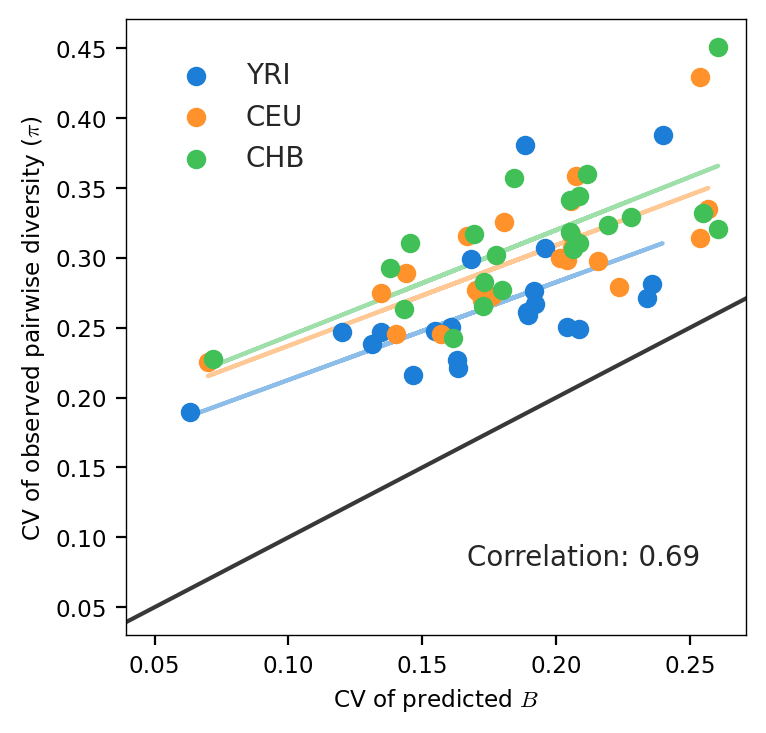

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
x, y = [], []
for pop in pops:
    d, p = list(cvs[pop][0].values()), list(cvs[pop][1].values())
    x.extend(d)
    y.extend(p)
    scatter = ax.scatter(p, d, label=pop.upper())
    m, b, *a = stats.linregress(p, d)
    ax.plot(p, [m * xi + b for xi in p], color=scatter.get_facecolor()[0], alpha=0.5, zorder=-10)

ax.set_xlabel('CV of predicted $B$')
ax.set_ylabel('CV of observed pairwise diversity ($\pi$)')
ax.axline((0.05, 0.05), slope=1, c='0.22')
ax.legend(ncol=1)

cc = np.corrcoef(x, y)[0, 1]
ax.text(
    
    0.55,
    0.15,
    f"Correlation: {cc:.2f}",
    transform=ax.transAxes,
    verticalalignment="top",
)

Text(0, 0.5, 'coefficient of variation in data')

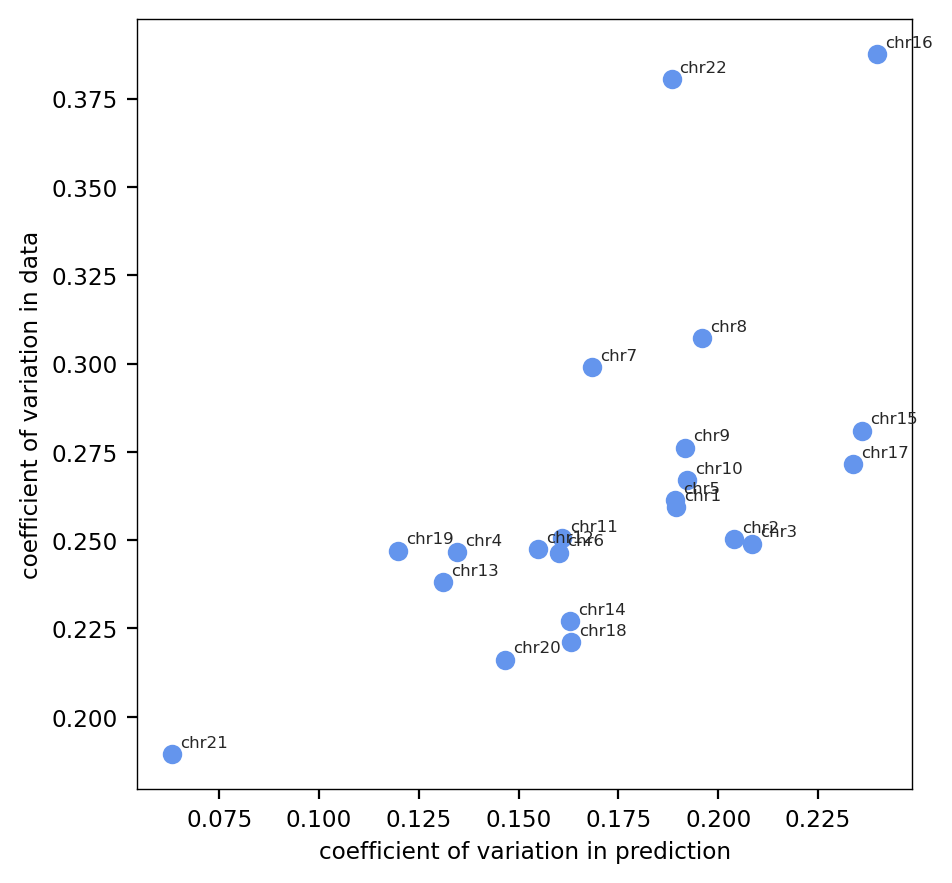

In [32]:
data_cfs, pred_cfs = cvs['yri']

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pred_cfs.values(), data_cfs.values(), c='cornflowerblue')

offset = 0.002
for key in pred_cfs.keys():
    x = pred_cfs[key]
    y = data_cfs[key]
    ax.text(x + offset, y + offset, key, fontsize=6)
ax.set_xlabel('coefficient of variation in prediction')
ax.set_ylabel('coefficient of variation in data')

In [ ]:
chrom = 'chr2'
cols = sns.color_palette()
    
figax = plt.subplots(figsize=(10, 3))
fig, ax = figax
pis = []
for i, pop in enumerate(pops):
    fit = pcg[pop]['mbp']
    midpoints, pi = fit.bins.pi_pairs(chrom)
    pis.append(pi)
    fit.predict_plot(chrom, figax=figax, pi_col='0.22', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())

ax.plot(midpoints, mean_ratio(np.nanmean(np.stack(pis), axis=0)), c='0.22', label='average')
ax.legend()
old_handles, old_labels = ax.get_legend_handles_labels()

handles, labels = [], []
for h, l in zip(old_handles, old_labels):
    if l == 'data':
        continue
    h.set_linewidth(2)
    handles.append(h)
    labels.append(l)
ax.legend(handles, labels, ncols=4, loc='upper center')

In [106]:
handles

[]